In [1]:
import os
"""
Comment it out the first time running the script on google colab to connect the driver
"""
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import copy

# **Section Summary**

- **Loading data**
- **Descriptive Analysis**
- **Data processing and feature extraction**
- **Model building and training**
- **Model evaluation**

# **Loading available data**

In [2]:
working_dir = "/content/drive/MyDrive/ChlorisGeospatial"

# Load the feature.npy file
file_path = os.path.join(working_dir, "features.npy")
image_data = np.load(file_path)

# Load the training.csv and testing.csv
train_df = pd.read_csv(os.path.join(working_dir, "training_data.csv"))
test_df = pd.read_csv(os.path.join(working_dir, "test_data.csv"))

In [3]:
image_data.shape

(4, 256, 256)

In [4]:
# Check data structure
train_df.head()

,col,row,agbd
0,241,62,0.0
1,187,179,256.0
2,197,25,211.0
3,56,65,437.0
4,128,71,433.0


In [5]:
train_df.shape

(20000, 3)

In [6]:
test_df.shape

(4000, 3)

# **Descriptive Analysis**

**Bands Visualization**

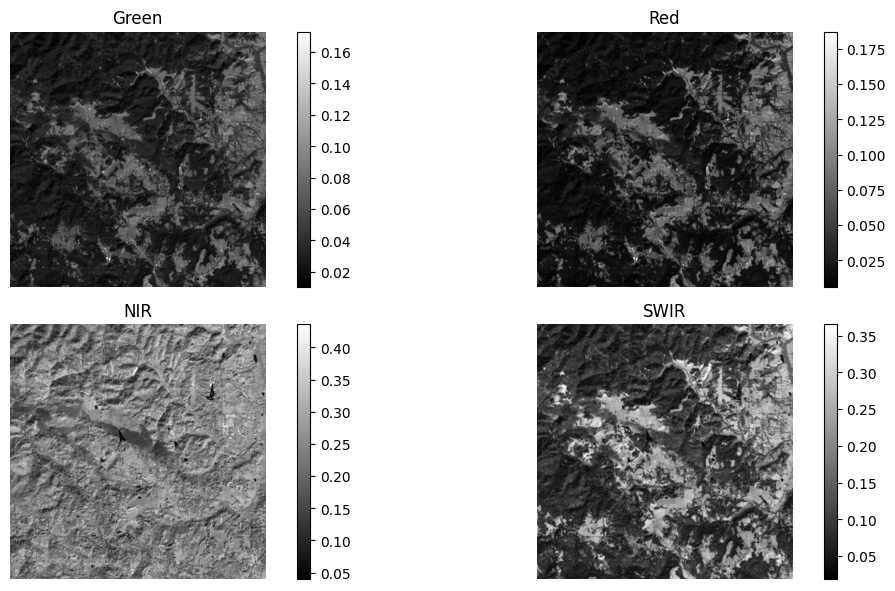

In [7]:
# Define band indices
band_labels = ["Green", "Red", "NIR", "SWIR"]
green, red, nir, swir = image_data

# Display individual bands
def plot_band(band, title, cmap='gray'):
    plt.imshow(band, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')

# Plot individual bands
plt.figure(figsize=(12, 6))
for i, (band, label) in enumerate(zip([green, red, nir, swir], band_labels)):
    plt.subplot(2, 2, i + 1)
    plot_band(band, label)

plt.tight_layout()
plt.show()

**Understand the NDVI**

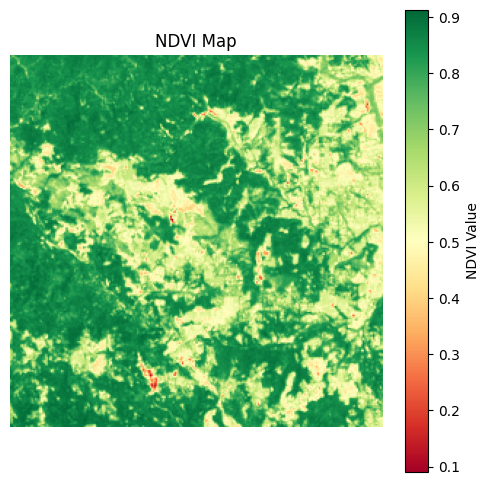

In [8]:
# Create NDVI visualization
ndvi = (nir - red) / (nir + red)
ndvi = np.clip(ndvi, -1, 1)  # Clip values to valid NDVI range (-1 to 1)

# Plot NDVI
plt.figure(figsize=(6, 6))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label="NDVI Value")
plt.title("NDVI Map")
plt.axis('off')
plt.show()

**Understand the NDWI**

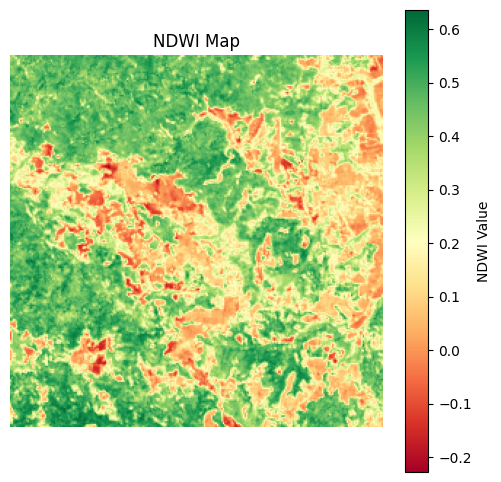

In [9]:
# Create NDWI visualization
ndwi = (nir - swir) / (nir + swir)
ndwi = np.clip(ndwi, -1, 1)  # Clip values to valid NDVI range (-1 to 1)

# Plot NDWI
plt.figure(figsize=(6, 6))
plt.imshow(ndwi, cmap='RdYlGn')
plt.colorbar(label="NDWI Value")
plt.title("NDWI Map")
plt.axis('off')
plt.show()

**Biomass distributionn**

<Axes: >

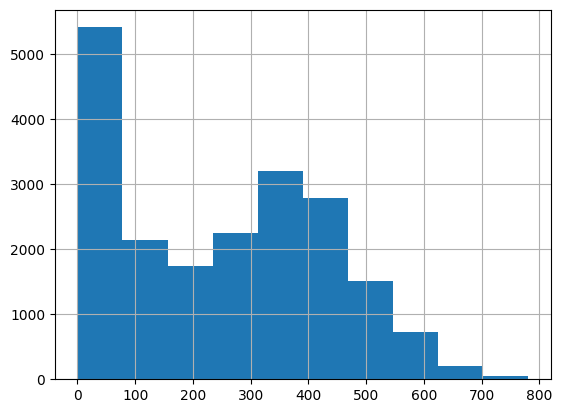

In [10]:
train_df["agbd"].hist()

<Axes: >

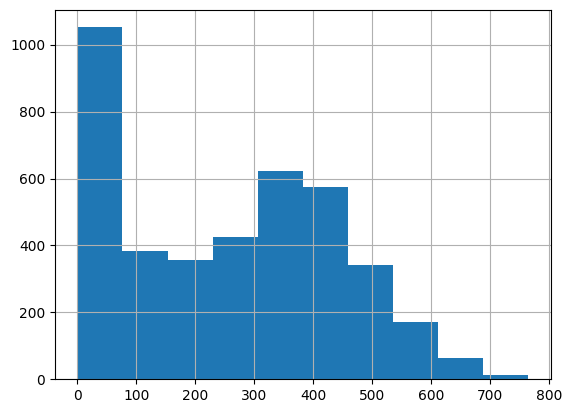

In [11]:
test_df["agbd"].hist()

**Data Preprocessing and feature extraction**

In [12]:
# Function to extract spectral band information for each col/row pair

def band_extraction(dataframe):
  """
  dataframe: a panda dataframe that include column name "col" and "row"
  return: a dataframe with spectral band green, red, nir, and swir information extracted for each col/row pairs
  """

  cols = dataframe["col"].to_numpy(dtype=int)
  rows = dataframe["row"].to_numpy(dtype=int)

  # Bounds checking: Create a valid mask
  valid_mask = (cols >= 0) & (cols < green.shape[1]) & (rows >= 0) & (rows < green.shape[0])

  # Initialize band arrays with NaN for invalid locations
  green_values = np.full_like(cols, np.nan, dtype=float)
  red_values = np.full_like(cols, np.nan, dtype=float)
  nir_values = np.full_like(cols, np.nan, dtype=float)
  swir_values = np.full_like(cols, np.nan, dtype=float)

  # Apply valid mask to extract values using NumPy indexing
  green_values[valid_mask] = green[rows[valid_mask], cols[valid_mask]]
  red_values[valid_mask] = red[rows[valid_mask], cols[valid_mask]]
  nir_values[valid_mask] = nir[rows[valid_mask], cols[valid_mask]]
  swir_values[valid_mask] = swir[rows[valid_mask], cols[valid_mask]]

  # Append the extracted band values to the DataFrame
  dataframe["green"] = green_values
  dataframe["red"] = red_values
  dataframe["nir"] = nir_values
  dataframe["swir"] = swir_values

  return dataframe

# Function to generate an indice
def gen_indice(band1, band2):
  """
  band1: band used in calculating an indice
  band2: band used in calculating an indice
  return: calculated indice
  """
  indice = (band1 - band2) / (band1 + band2)
  return indice

**Understanding the distribution of features**

In [13]:
# Spectral band data extraction and indices extraction for training data
train_df = band_extraction(train_df)
# Add NDVI for vegetation health/abundant
train_df["ndvi"] = train_df.apply(lambda x: gen_indice(x["nir"], x["red"]), axis=1)
# Add NDWI for water content of vegetation
train_df["ndwi"] = train_df.apply(lambda x: gen_indice(x["nir"], x["swir"]), axis=1)

# Spectral band data extraction and indices extraction for testing data
test_df = band_extraction(test_df)
test_df["ndvi"] = test_df.apply(lambda x: gen_indice(x["nir"], x["red"]), axis=1)
test_df["ndwi"] = test_df.apply(lambda x: gen_indice(x["nir"], x["swir"]), axis=1)

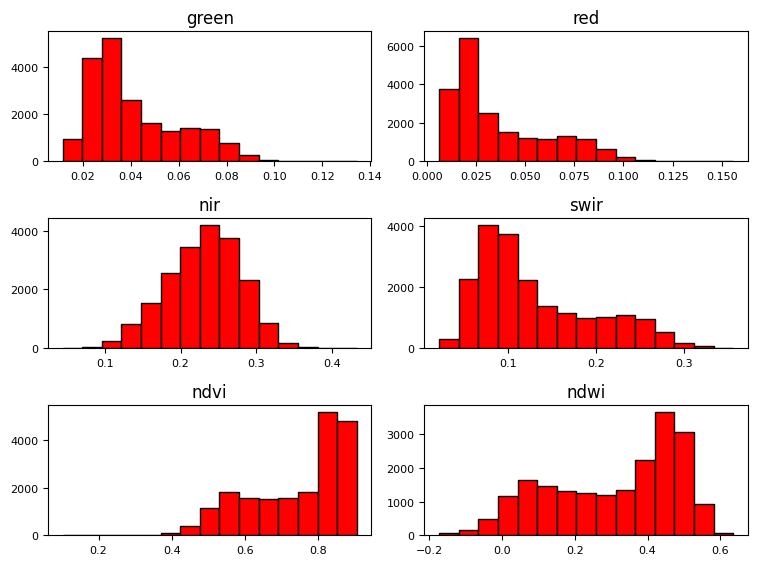

In [14]:
train_df[["green", "red", "nir", "swir", "ndvi", "ndwi"]].hist(bins=15, color='red', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

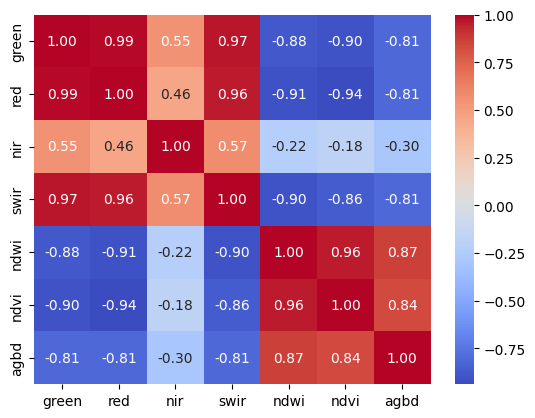

In [15]:
import seaborn as sns

vis_col = ["green", "red", "nir", "swir", "ndwi", "ndvi", "agbd"] # create a new list of columns to visulize the correlations

correlation_matrix = train_df[vis_col].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# **Model building, training, and testing**

# **1. Random forest**


*   Model training
*   Model validation with validation and testing dataset
*   Model explanation



**Model training with all parameters as default**

In [16]:
# Prepare the data for model training

selected_column = ["green", "red", "nir", "swir", "ndwi", "ndvi"]

X = train_df[selected_column]
y = train_df['agbd']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [17]:
# Make predictions on the validation set
y_pred = rf_model.predict(X_val)

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
print("The Mean Squared Error of random forest method for validation data is {}".format(mse))

rmse = np.sqrt(mse)
print("The RMSE of random forest method for validation data is {}".format(rmse))

r_squared = r2_score(y_val, y_pred)
print("The R-squared of random forest method for validation data is {}".format(r_squared))

The Mean Squared Error of random forest method for validation data is 6981.41447965
The RMSE of random forest method for validation data is 83.55485910256806
The R-squared of random forest method for validation data is 0.7957856820703162


**Model valiation with independent testing data**

In [18]:
# Prepare the data for model testing
X_test = test_df[selected_column]
y_test = test_df['agbd']

# Make predictions on the validation set
y_test_pred = rf_model.predict(X_test)

# Evaluate the model with independent testing data
mse_test = mean_squared_error(y_test, y_test_pred)
print("The Mean Squared Error of random forest method for testing data is {}".format(mse_test))

rmse_test = np.sqrt(mse_test)
print("The RMSE of random forest method for testing data is {}".format(rmse_test))

r_squared_test = r2_score(y_test, y_test_pred)
print("The R-squared of random forest method for testing data is {}".format(r_squared_test))

The Mean Squared Error of random forest method for testing data is 7377.36531855
The RMSE of random forest method for testing data is 85.89159049959432
The R-squared of random forest method for testing data is 0.7858438118057177


**Parameter tuning with gridsearch**

In [19]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt']
}

# Instantiate the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE: 83.05188494852479


In [20]:
# Evaluate the best rf model
mse_test = mean_squared_error(y_test, y_test_pred)
print("The Mean Squared Error of random forest method for testing data is {}".format(mse_test))

rmse_test = np.sqrt(mse_test)
print("RMSE:", rmse)

r_squared_test = r2_score(y_test, y_test_pred)
print("The R-squared of random forest method for testing data is {}".format(r_squared_test))

The Mean Squared Error of random forest method for testing data is 7377.36531855
RMSE: 83.05188494852479
The R-squared of random forest method for testing data is 0.7858438118057177


**Feature importance: Understand the importance of each feature contributing to the model performance**

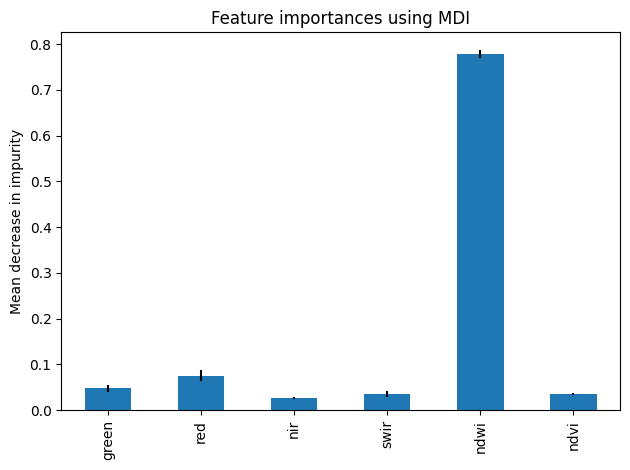

In [21]:
# Extract feature importances
importances = rf_model.feature_importances_

forest_importances = pd.Series(importances, index=selected_column)

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Prediction Uncertainty (This code comes from ChatGPT)**

Mean Squared Error: 7154.9687094625015
Root Mean Squared Error: 84.58704811886098


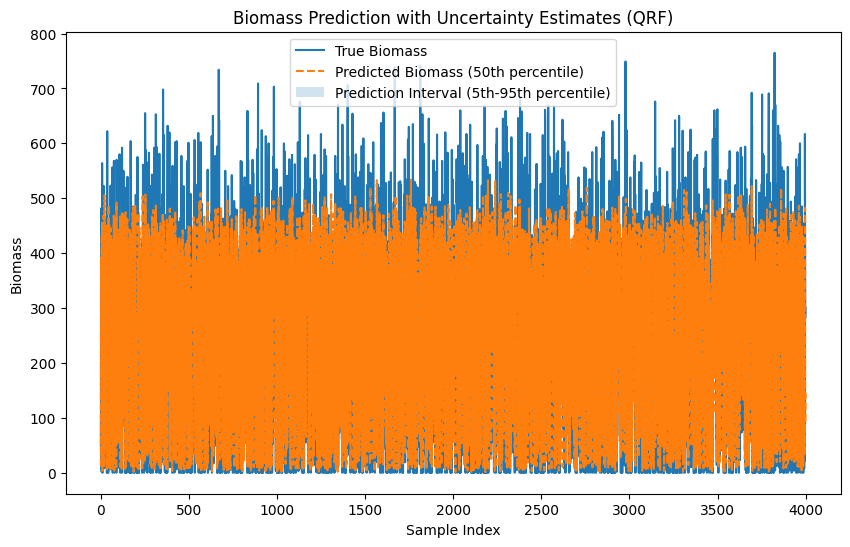

In [22]:
# Instantiate the RandomForestRegressor model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to training data
rf.fit(X_train, y_train)

# Predict the biomass values using the trained Random Forest model
y_pred = rf.predict(X_test)

# To estimate the quantiles, you can use the `predict()` method multiple times with different bootstrap samples
# Quantile prediction for 5th, 50th (median), and 95th percentiles
n_bootstrap = 20  # Number of bootstrap samples
y_pred_5 = np.zeros((n_bootstrap, len(X_test)))
y_pred_50 = np.zeros((n_bootstrap, len(X_test)))
y_pred_95 = np.zeros((n_bootstrap, len(X_test)))

for i in range(n_bootstrap):
    # Bootstrap sample indices
    sample_indices = np.random.choice(np.arange(len(X_train)), size=len(X_train), replace=True)

    X_train_sample = X_train.iloc[sample_indices]
    y_train_sample = y_train.iloc[sample_indices]

    # Train a new RandomForest on the bootstrap sample
    rf.fit(X_train_sample, y_train_sample)

    # Get predictions for the test set
    y_pred_5[i] = rf.predict(X_test)

# Calculate the quantiles (5th, 50th, and 95th percentiles)
y_pred_05 = np.percentile(y_pred_5, 5, axis=0)
y_pred_50 = np.percentile(y_pred_5, 50, axis=0)
y_pred_95 = np.percentile(y_pred_5, 95, axis=0)

# Calculate MSE and RMSE for the 50th percentile predictions
mse = mean_squared_error(y_test, y_pred_50)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

# Visualizing the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Biomass')
plt.plot(y_pred_50, label='Predicted Biomass (50th percentile)', linestyle='--')
plt.fill_between(range(len(y_test)), y_pred_05, y_pred_95, alpha=0.2, label='Prediction Interval (5th-95th percentile)')
plt.legend()
plt.title('Biomass Prediction with Uncertainty Estimates (QRF)')
plt.xlabel('Sample Index')
plt.ylabel('Biomass')
plt.show()

In [23]:
mse = mean_squared_error(y_test, y_pred_50)

In [24]:
r2_score(y_test, y_pred_50)

0.792299722284999

# **2. Multilayer perceptron (MLP)**

**Build a very simple MLP model with only 3 layer**

In [25]:
# Construct a dataloader to process the data to make it ready for model training

class BiomassDataset(Dataset):
  """
  Prepare the dataset
  """

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]


class MLP(nn.Module):
  """
    Multilayer Perceptron for regression.
  """
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(4, 64),
      nn.ReLU(),
      nn.Linear(64, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 1)
    )


  def forward(self, x):
    return self.layers(x)


In [26]:
train_df.columns

Index(['col', 'row', 'agbd', 'green', 'red', 'nir', 'swir', 'ndvi', 'ndwi'], dtype='object')

**Construct the training data without feature engineering**

In [27]:
X = train_df[["green", "red", "nir", "swir"]]
y = train_df['agbd']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:

# Set fixed random number seed
torch.manual_seed(42)

# Prepare the training and valiation data, they come from the same data that RF used for training and validation
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

train_dataset = BiomassDataset(X_train, y_train)
val_dataset = BiomassDataset(X_val, y_val)

# Create a dataloader for both training and validation dataset
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=1)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=1)

# Initialize the MLP
model = MLP()
epochs = 20 # training epochs

# Define the loss function and optimizer
loss_function = nn.L1Loss() # nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Hold the best model
best_val_loss = np.inf
best_weights = None
history = {"train_loss": [], "val_loss": []} # keeping the record of loss values for each epoch, so easy to visualize the loss

# Run the training loop
for epoch in range(0, epochs):
  print(f'Starting epoch {epoch+1}')

  model.train()
  # Set current loss value
  running_loss = 0.0

  # Iterate over the DataLoader for training data
  for i, data in enumerate(trainloader, 0):

    # Get and prepare inputs
    inputs, targets = data[0].float(), data[1].float()
    targets = targets.reshape((targets.shape[0], 1))

    # Zero the gradients
    optimizer.zero_grad()

    # Perform forward pass
    outputs = model(inputs)

    # Compute loss
    loss = loss_function(outputs, targets)

    # Perform backward pass
    loss.backward()

    # Perform optimization
    optimizer.step()

    # Print statistics
    running_loss += loss.item()

  # Validation for each epoch
  model.eval()
  val_loss = 0.0

  with torch.no_grad():  # Disable gradient computation for validation
    for inputs, targets in valloader:
      inputs, targets = inputs.float(), targets.float().view(-1, 1)
      outputs = model(inputs)
      loss = loss_function(outputs, targets)
      val_loss += loss.item()

  val_loss /= len(valloader)  # Compute average validation loss
  history["train_loss"].append(running_loss / len(trainloader))
  history["val_loss"].append(val_loss)

  # Save best model weights based on validation loss
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_weights = copy.deepcopy(model.state_dict())

# Process is complete.
print('Training process has finished.')

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Training process has finished.


In [29]:
X_test = test_df[["green", "red", "nir", "swir"]]
y_test = test_df['agbd']

X_test, y_test = np.array(X_test), np.array(y_test)
test_dataset = BiomassDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=1)

predictions = []

with torch.no_grad():  # Disable gradient calculation for inference
  for batch in testloader:
    inputs = batch[0].float()
    outputs = model(inputs)
    predictions.extend(outputs.numpy().flatten())  # Convert to list

# Convert predictions to np array
predictions = np.array(predictions)


In [30]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
r_squared_test = r2_score(y_test, predictions)
print("R-squared:", r_squared_test)

Mean Squared Error: 7161.144890012928
RMSE: 84.62354808215576
R-squared: 0.7921204350696901


**Model prediction and mapping**

In [31]:
# prepare the features for prediction
features = image_data.reshape(4, -1).T

In [32]:
features.shape

(65536, 4)

In [33]:
model.eval()  # Set the MLP model to evaluation mode

# convert the features to tensors
features_tensor = torch.tensor(features, dtype=torch.float32)

# Model prediction
with torch.no_grad(): # no gradient
    biomass_predictions = model(features_tensor)

biomass_predictions = biomass_predictions.numpy().flatten()

# reshape back to original size (image_data is the .npy feature layer)
biomass_map = biomass_predictions.reshape((1, image_data.shape[1], image_data.shape[2]))

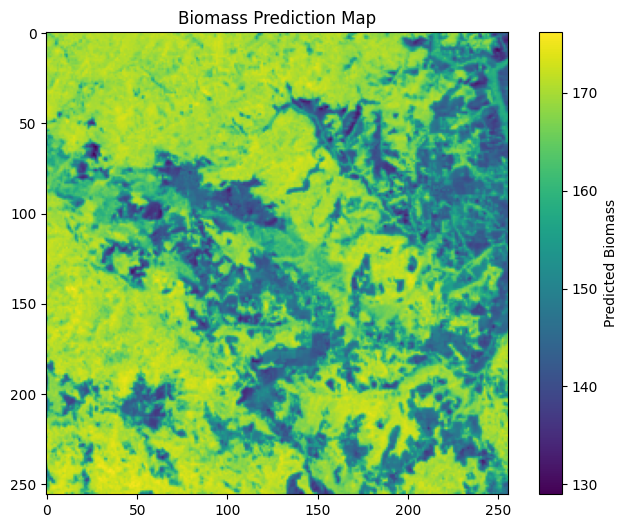

In [34]:
# Visualize the biomass prediction map
plt.figure(figsize=(8, 6))
plt.imshow(biomass_map[0], cmap='viridis')
plt.colorbar(label="Predicted Biomass")
plt.title("Biomass Prediction Map")
plt.show()